<a href="https://colab.research.google.com/github/andreaaraldo/mining-low-dim-network-data/blob/temp/BarcelonaCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has been forked from the [repository of Prof. Marc Crovella](https://github.com/mcrovella/mining-low-dim-network-data), Boston University.

<BR>
<BR>
<center>
<font size='18'>Data Mining of Network Measurements<BR><BR><BR></font>
A short course at the 5th PhD School on Traffic Monitoring and Analysis
<BR><BR>
Barcelona
<BR><BR>
April 22, 2015
<BR><BR><BR><BR><BR>
Mark Crovella
<BR>
<IMG src='https://github.com/andreaaraldo/mining-low-dim-network-data/blob/master/images/BUlogo.png?raw=1' width=150/>
</center>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [ ]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

## My Claim



__In the aggregate, "normal" human activity is frequently low-dimensional.__


I'll call this the "low-dimensional phenomenon."

In the rest of this lecture I'll answer these two questions:

1. What does "the low-dimensional phenomenon" mean?

2. Why does "the low-dimensional phenomenon" matter?

## Empirical Evidence

Let's see how dimensionality reduction can be used in practice, and investigate some real data.

We'll look at OD flow traffic on the Abilene network:

<img src='https://github.com/andreaaraldo/mining-low-dim-network-data/blob/master/images/Abilene-map.png?raw=1'>

Source: Internet2, circa 2005

*Araldo*: 
We now donwload the data from the repository of Marc Crovella. The commands are inspired by [this post](https://github.community/t5/How-to-use-Git-and-GitHub/How-can-I-download-a-specific-folder-from-a-GitHub-repo/m-p/95/highlight/true#M23).

In [ ]:
! mkdir data
! cd data
! git init
! git remote add origin -f https://github.com/mcrovella/mining-low-dim-network-data
! echo "data" > .git/info/sparse-checkout
! git pull origin master

with open('data/net-traffic/AbileneFlows/odnames','r') as f:
    odnames = [line.strip() for line in f]

Atraf = pd.read_table('data/net-traffic/AbileneFlows/X',sep='  ',header=None,
                      names=odnames,engine='python')

mkdir: cannot create directory ‘data’: File exists
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/mcrovella/mining-low-dim-network-data
 * branch            master     -> FETCH_HEAD
Already up to date.


*Araldo*: 
We know from the description of the dataset, that each sample represents a period of 10 min and that we have 1 week measurements (and thus we have 1008 periods in total). We can thus index the dataset, with the corresponding column of time-stamps. To do so, we first create the vector `dates`, and then we set it as the index of the dataframe.

*Araldo*: Each column counts the amount of bytes flowing between the Origin-Destination (OD) pair of nodes.

In [ ]:
dates = pd.date_range('9/1/2003',freq='10min',periods=1008)

Atraf.index = dates
Atraf

,ATLA-ATLA,ATLA-CHIN,ATLA-DNVR,ATLA-HSTN,ATLA-IPLS,ATLA-KSCY,ATLA-LOSA,ATLA-NYCM,ATLA-SNVA,ATLA-STTL,ATLA-WASH,CHIN-ATLA,CHIN-CHIN,CHIN-DNVR,CHIN-HSTN,CHIN-IPLS,CHIN-KSCY,CHIN-LOSA,CHIN-NYCM,CHIN-SNVA,CHIN-STTL,CHIN-WASH,DNVR-ATLA,DNVR-CHIN,DNVR-DNVR,DNVR-HSTN,DNVR-IPLS,DNVR-KSCY,DNVR-LOSA,DNVR-NYCM,DNVR-SNVA,DNVR-STTL,DNVR-WASH,HSTN-ATLA,HSTN-CHIN,HSTN-DNVR,HSTN-HSTN,HSTN-IPLS,HSTN-KSCY,HSTN-LOSA,...,NYCM-IPLS,NYCM-KSCY,NYCM-LOSA,NYCM-NYCM,NYCM-SNVA,NYCM-STTL,NYCM-WASH,SNVA-ATLA,SNVA-CHIN,SNVA-DNVR,SNVA-HSTN,SNVA-IPLS,SNVA-KSCY,SNVA-LOSA,SNVA-NYCM,SNVA-SNVA,SNVA-STTL,SNVA-WASH,STTL-ATLA,STTL-CHIN,STTL-DNVR,STTL-HSTN,STTL-IPLS,STTL-KSCY,STTL-LOSA,STTL-NYCM,STTL-SNVA,STTL-STTL,STTL-WASH,WASH-ATLA,WASH-CHIN,WASH-DNVR,WASH-HSTN,WASH-IPLS,WASH-KSCY,WASH-LOSA,WASH-NYCM,WASH-SNVA,WASH-STTL,WASH-WASH
2003-09-01 00:00:00,8466132.0,29346537.0,15792104.0,3646187.0,21756443.0,10792818.0,14220940.0,25014340.0,13677284.0,10591345.0,44830710.0,22162644.0,10569554.0,8508784.0,6066791.0,28761923.0,14757430.0,19808715.0,30512810.0,12702092.0,6238925.0,34567357.0,15011881.0,21515113.0,7438737.0,5022386.0,35788370.0,12343491.0,7011763.0,26119304.0,5663777.0,7064714.0,15275151.0,3658793.0,7438930.0,1986445.00,4753711.0,8410876.0,1876191.00,3112648.0,...,64718460.0,19610639.0,33304184.0,97533196.0,25556204.0,27523690.0,116960980.0,8376490.0,19154272.0,2919897.0,4193259.0,14772857.0,5001149.0,25578727.0,44853512.0,31270597.0,47084483.0,19710392.0,8896031.0,11377231.0,5445580.0,1332575.0,8172236.0,2238361.0,9933653.0,22113886.0,18206254.0,1306840.0,11007385.0,34417418.0,53296727.0,18724766.0,12238893.0,52782009.0,12836459.0,31460190.0,105796930.0,13756184.0,13582945.0,120384980.0
2003-09-01 00:10:00,20524567.0,28726106.0,8030109.0,4175817.0,24497174.0,8623734.0,15695839.0,36788680.0,5607086.0,10714795.0,53497313.0,23544876.0,14036027.0,10365533.0,6680411.0,30020293.0,16365005.0,19955891.0,32125614.0,14085997.0,8234277.0,32294560.0,16074873.0,21941937.0,6278290.0,5040748.0,42353104.0,13210411.0,6057381.0,26377858.0,5353211.0,7185921.0,17881840.0,4210651.0,7045592.0,1902574.00,5752071.0,9474470.0,2165768.00,2839805.0,...,70720164.0,18776161.0,39921334.0,102049160.0,26199881.0,26840222.0,116668960.0,11207512.0,24004399.0,3983489.0,10922988.0,17708735.0,4876484.0,27716512.0,43867847.0,30872406.0,53927107.0,20496382.0,10473794.0,11806536.0,6806334.0,2265811.0,8413283.0,6142062.0,10294307.0,21082187.0,18054608.0,1093814.0,12029267.0,44454956.0,68413060.0,28522606.0,11377094.0,60006620.0,12556471.0,32450393.0,70665497.0,13968786.0,16144471.0,135679630.0
2003-09-01 00:20:00,12864863.0,27630217.0,7417228.0,5337471.0,23254392.0,7882377.0,16176022.0,31682355.0,6354657.0,12205515.0,51596252.0,25348900.0,16634715.0,12887229.0,8246765.0,35265859.0,16732868.0,22674460.0,30838759.0,13166694.0,10632215.0,36546522.0,19488876.0,19335063.0,5898726.0,4741619.0,38150752.0,13021727.0,4825252.0,24939423.0,4854303.0,7496997.0,17969759.0,4211578.0,7987543.0,2010440.00,5553520.0,9197589.0,2618806.00,3516418.0,...,76030907.0,15554515.0,37256894.0,109862510.0,28772784.0,30095748.0,119826040.0,10297431.0,22669657.0,4525107.0,7299554.0,17286210.0,4154580.0,27020243.0,35381455.0,30889830.0,65203292.0,21555842.0,9825472.0,11784056.0,5832191.0,3369264.0,10667507.0,6828729.0,9590491.0,22949595.0,16761744.0,1480914.0,11563538.0,65794419.0,67969461.0,37073856.0,15680615.0,61484233.0,16318506.0,33768245.0,71577084.0,13938533.0,14959708.0,126175780.0
2003-09-01 00:30:00,10856263.0,32243146.0,7136130.0,3695059.0,28747761.0,9102603.0,16200072.0,27472465.0,9402609.0,10934084.0,44675780.0,25069050.0,18162949.0,13055269.0,7508872.0,46116847.0,15256759.0,21829227.0,31231279.0,14604476.0,9629606.0,36046933.0,16872715.0,20313756.0,6924307.0,4918902.0,39253241.0,12866088.0,6586184.0,27583659.0,11024706.0,7633286.0,19032696.0,3925047.0,10463906.0,1692982.00,5281998.0,10595918.0,1963792.00,4890696.0,...,76365697.0,15811670.0,34575308.0,110651500.0,27099173.0,30047305.0,126138790.0,8310940.0,2474860

*Araldo*: **Attention to standardizing and centering**

Your dataset may have columns with different magnitudes, e.g., columms are in different unities of measurement, for instance bytes, gygabytes, 5-stars-ratings and audio bitrates all in the same dataset, if you apply Singular Value Decomposition (SVD) right away, the columns with the highest magnitude risk to monopolize the decomposition. 

In such cases, it is advisable to apply StandardScaler to your dataset and apply SVD to the transformed dataset. Observe that Standard scaling also center all the columns of the dataset around their mean, which is also useful, as it makes the decomposition insensible to the mean of each column.

However, in this notebook, Marc Crovella decided not to scale and center the dataset. In his case, this is acceptable, as all the columns have the same semantics and the same magnitude (they are all traffic counts).

To know more about scaling and dimensionality reduction, check Sec.11.5 of [11].

*Araldo*: 
The function `np.linalg.svd(..)` performs Singular Value Decomposition.

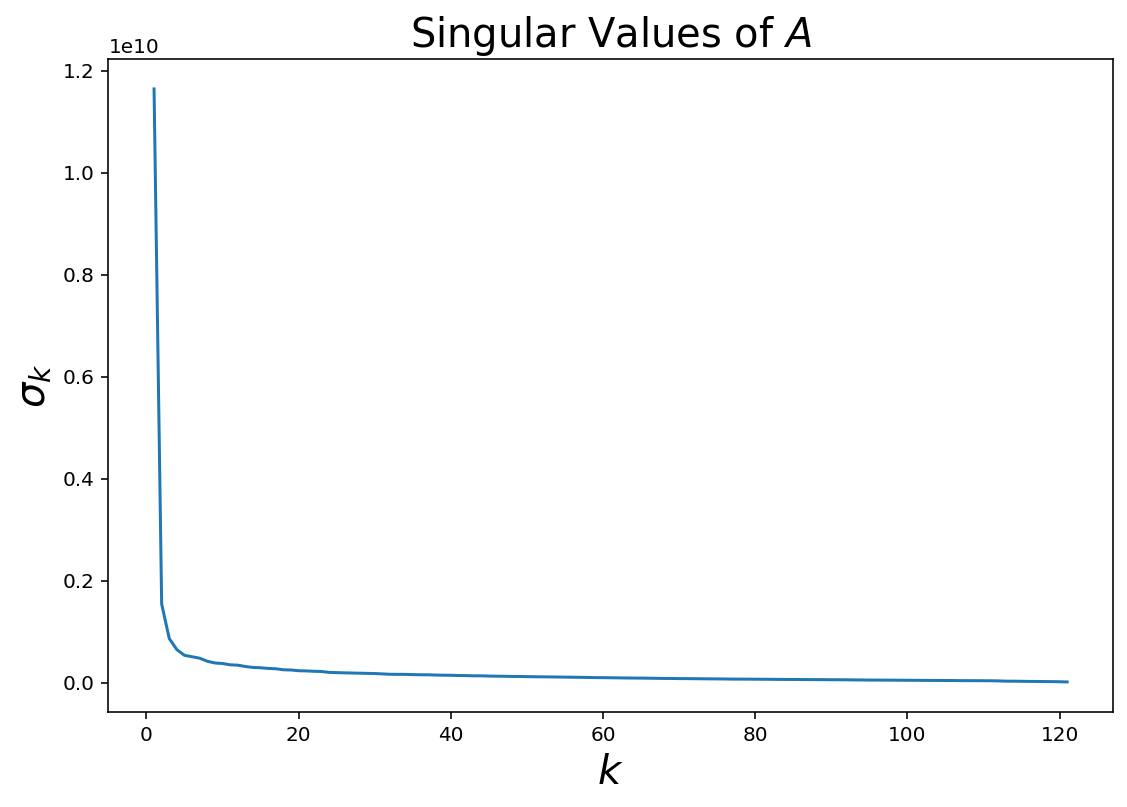

In [ ]:
U,Sigma,Vt = np.linalg.svd(Atraf)

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(Sigma)),Sigma)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
plt.title(r'Singular Values of $\mathbf{A}$',size=20)
print('')

*Araldo*: We now just plot the first 20 singular values, normalized by the norm of $\mathbf{A}$.

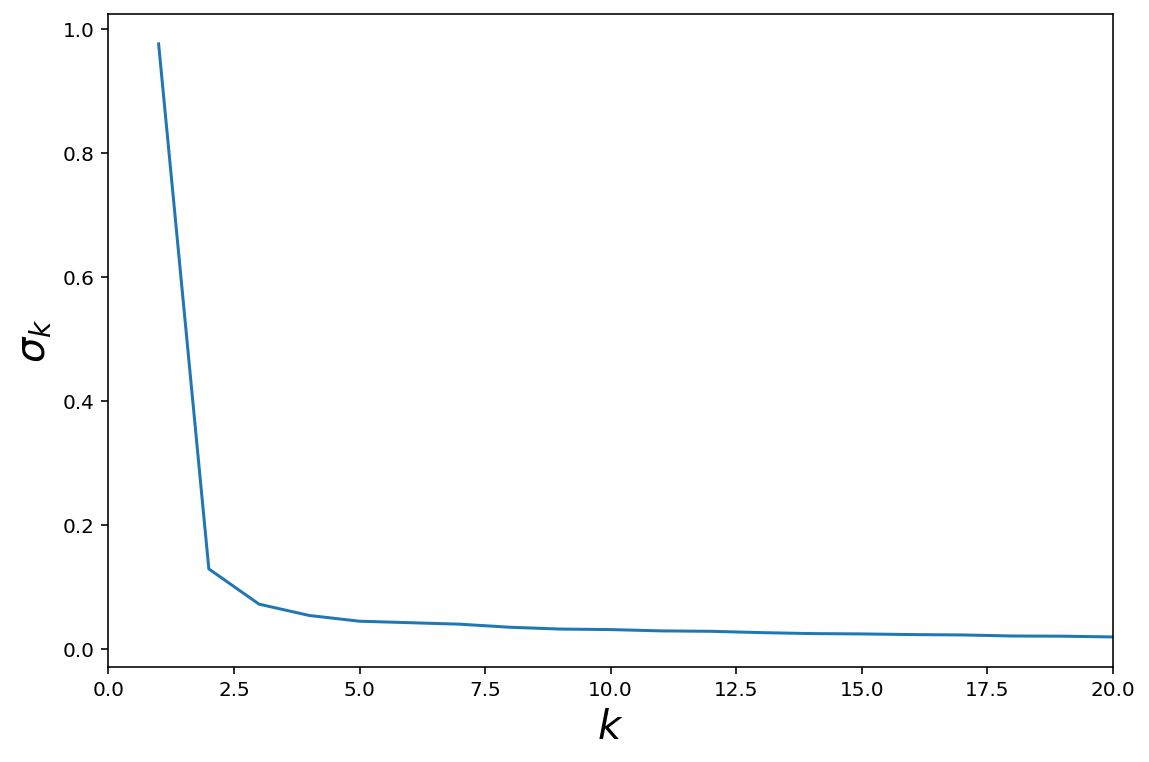

In [ ]:
Anorm = np.linalg.norm(Atraf)

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,21),s[0:20]/Anorm)
plt.xlim([0,20])
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
print('')

*Araldo*: The theory (slides) tells us that the approximation error when reconstructing $\mathbf{A}$ using only $k$ principal components is
$$ \text{err} =\sqrt{\sigma_{r-k}^2+\sigma_{r-k+1}^2+\dots+\sigma_r^2}
$$

In [ ]:
Anorm = np.linalg.norm(Atraf) # Froebenius norm
err = np.cumsum(Sigma[::-1]**2)
err = np.sqrt(err[::-1])
plt.plot(range(1,21),err[:20]/Anorm) # Error in percentage

# Plotting
fig = plt.figure(figsize=(9,6))
plt.xlim([0,20])
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'relative F-norm error',size=20)
plt.title(r'Relative Error of rank-$k$ approximation to $A$',size=20)
print('')

In [ ]:
s[0:10]/Anorm

array([0.97599686, 0.12922614, 0.07240894, 0.05414364, 0.04488242,
       0.04251024, 0.0401026 , 0.03513407, 0.0322399 , 0.03139553])

So we are down to 4% relative error using only the 7 vectors $\{\vu_1,\dots,\vu_7\}$ to describe all the columns of $A$.

#### Likes on Facebook.

Here, the matrices are 

1. Number of likes:  Timebins $\times$ Users
2. Number of likes:  Users $\times$ Page Categories
3. Entropy of likes across categories:  Timebins $\times$ Users

<center>
<img width=650, src = images/facebook.png/>
</center>

Source: [Viswinath et al.]

#### Social Media Activity.

Here, the matrices are 

1. Number of Yelp reviews:  Timebins $\times$ Users
2. Number of Yelp reviews:  Users $\times$ Yelp Categories
3. Number of Tweets:  Users $\times$ Topic Categories

<center>
<img width=650, src = images/yelp-twitter.png/>
</center>

Source: [Viswinath et al.]

#### User preferences over items.

Example: the Netflix prize worked with partially-observed matrices like this:

$$\left[\begin{array}{ccccccc}
  ~&~&~&\vdots&~&~&~\\
  &~&3&2&~&1&\\
  &1&~&1&~&~&\\
  \dots&~&2&~&4&~&\dots\\
  &5&5&~&4&~&\\
  &1&~&~&1&5&\\
  ~&~&~&\vdots&~&~&~\\
\end{array}
\right]
$$

Where the rows correspond to users, the columns to movies, and the entries are ratings.

Although the problem matrix was of size 500,000 $\times$ 18,000, the winning approach modeled the matrix as having __rank 20 to 40.__

## Interpretations of the Low-Dimensional Phenomenon

How can we understand this low-dimensional phenomenon in general?

There are two helpful interpretations:

1. Common Patterns
2. Latent Factors

### Common Patterns.

$$ A \approx U'\Sigma'(V')^T $$

In this interpretation, we think of each sample (column of $A$) as a combination of the columns of $U'$.

Let's use as our example $\va_1,$ the first column of $A$

The equation above tells us that

$$\va_1 \approx v_{11}\sigma_1\vu_1 + v_{12}\sigma_2\vu_2 + \dots + v_{1k}\sigma_k\vu_k.$$

In other words, $\vu_1$ (the first column of $U$) is the "strongest" pattern occurring in $A$, and its strength is measured by $\sigma_1$.

Here is an view of the first few columns of $U\Sigma$ for the traffic matrix data:

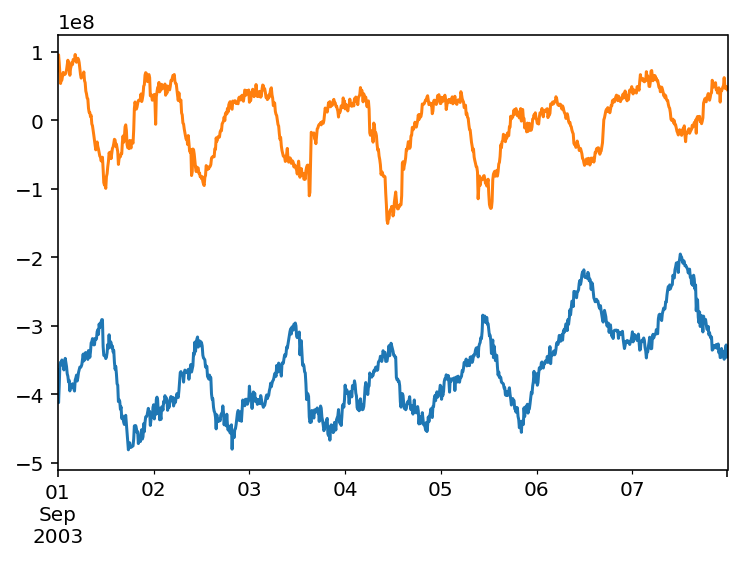

In [ ]:
u,s,vt = np.linalg.svd(Atraf,full_matrices=False)
uframe = pd.DataFrame(u.dot(np.diag(s)),index=pd.date_range('9/1/2003',freq='10min',periods=1008))
uframe[0].plot()
uframe[1].plot()

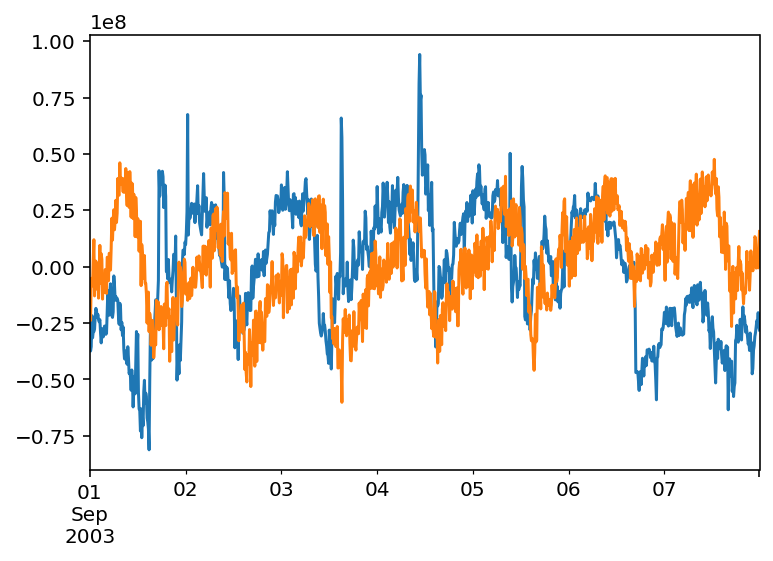

In [ ]:
uframe[2].plot()
uframe[3].plot()

# Why Does the Low-Dimensional Phenomenon Matter?

We'll discuss two ways to exploit the low-dimensional phenomenon:

1. Anomaly Detection
2. Matrix Completion

## Anomaly Detection via the Low-Dimensional Phenomenon

The first application of the phenomenon is anomaly detection.

The anomaly detection problem is as follows: given a population $P$, divide the members of $P$ in a normal set $N$ and an anomalous set $O$.

We can use dimensionality reduction to perform anomaly detection in an unsupervised way (no need for labeled data)

We make the assumption that in the dataset $P$, __the majority of samples are normal.__

Therefore, the samples that are "different" can be classified as anomalies (or abnormal points)

In practice, given a set of measurements:

* Assume that “most” observations are normal
* Build a low-dimensional (linear) model for them
* What is not well predicted is anomalous and most likely some form of misbehavior


In practice, this is a simple process.

Given a data matrix $A$:

1.  Compute the Singular value decomposition of $A$, $$U\Sigma V^T = A.$$
2.  Compute a low-rank approximation to $A$, using only $k$ components: $$N = U_k \cdot \Sigma_k \cdot V_k^T.$$
3.  Compute the data not explained by $N$:  $$O = A-N.$$
4.  Indentify the rows of $O$ with largest $\ell_2$ (Euclidean) norm: these rows correspond to anomalies.

There are two unspecified steps in the process:

1. Selecting the number of components $k$.
2. Deciding how many of the largest rows of $O$ are anomalies.

For 1, the general idea is to choose a $k$ at the knee of the singular value plot.  
For 2, there are statistical methods that generally work reasonably well.

### Example 1: Traffic OD Flows

This data consists of the number of bytes flowing between 121 origin-destination pairs in the Abilene network, sampled at 10 minute intervals, for one week.

Rows (samples) are timebins, Columns are source-destination pairs.

First we will look at the columns of $U$.

Text(0.5, 0.98, 'First 12 Columns of $U$')

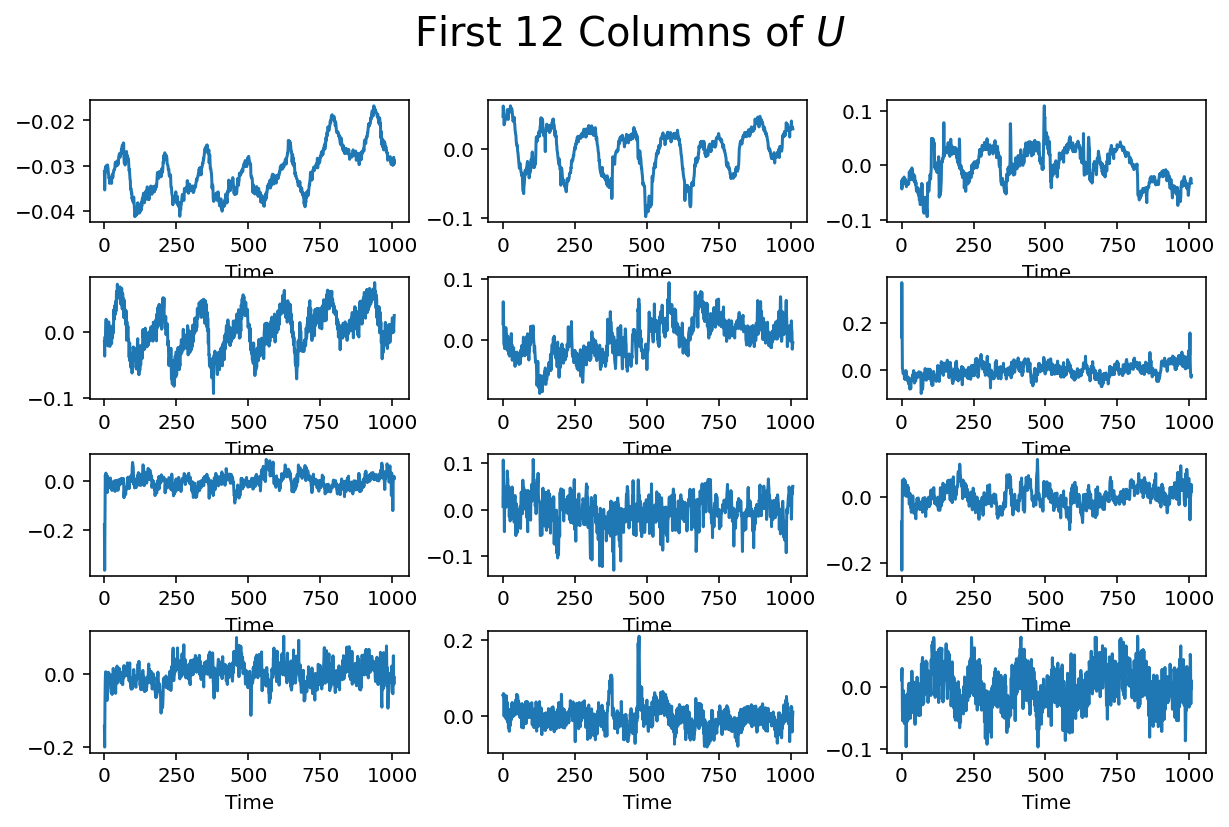

In [ ]:
U,Sigma,Vt = np.linalg.svd(Atraf,full_matrices=False)

### Plotting
plt.figure(figsize=(10,6))
for i in range(1,13):
    ax = plt.subplot(4,3,i)
    plt.plot(U[:,i-1])
    plt.xlabel('Time')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('First 12 Columns of $U$',size=20)

Next we will extract the anomalous traffic and look at its volume at each time point.

*Araldo*: Here I modified a bit the following code with respect to the original  notebook

Text(0.5, 1.0, '$\\ell_2$ Norm of Anomalous Traffic')

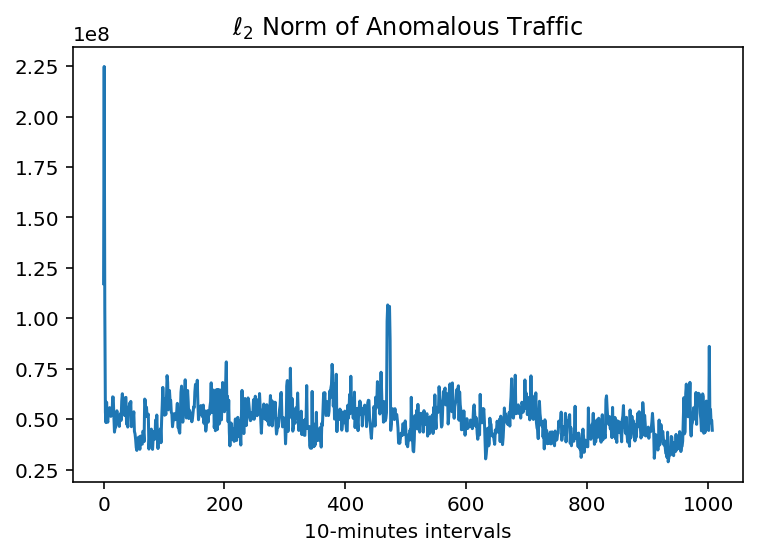

In [ ]:
k=6 # Number of components

U_k = U[:,0:k]
Sigma_k = np.diag(Sigma[0:k])
v_k_t = Vt[0:k,:]

Ntraf = np.dot(U_k, np.dot(Sigma_prime, V_k_t) )

Otraf = Atraf - Ntraf

# For each time-slot, it quantifies the "amount of anormality"
Onorm = np.linalg.norm(Otraf,axis=1) 


### Plotting
plt.plot(Onorm)
plt.xlabel('10-minutes intervals')
plt.title(r'$\ell_2$ Norm of Anomalous Traffic')

Now we'll choose the top 15 anomalous time points and look at where they fall.

Text(0.5, 0, '10-minutes intervals')

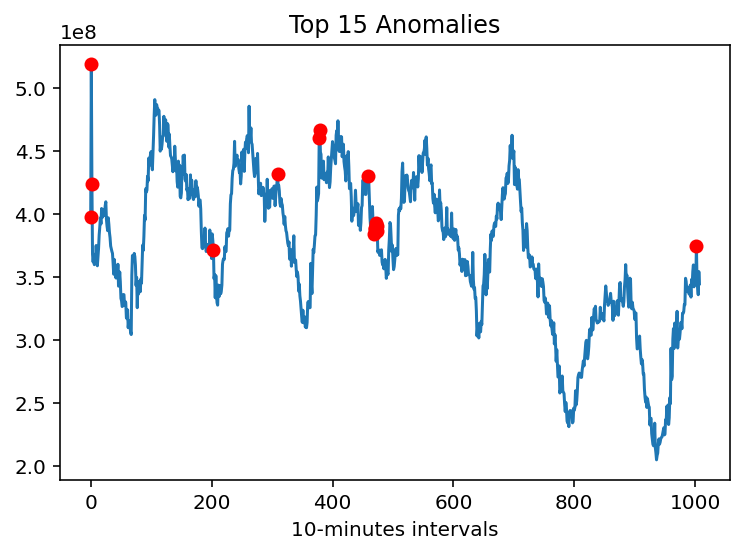

In [ ]:
# choose the top 15 anomalies
anomalies = np.argsort(Onorm)[-15:]

### Plotting
# First, plot the amount of total traffic
Anorm = np.linalg.norm(Atraf,axis=1)
plt.plot(Anorm)

# Them, plot a circle per each anomalous time interval
plt.plot(anomalies,Anorm[anomalies],'ro')
plt.title('Top 15 Anomalies')
plt.xlabel('10-minutes intervals')

### Example 2: Facebook Spatial Likes

*Araldo*: We want to recognize "fake" users, i.e., profiles created (or legitimate profiles compromised) in order to perform malicious activity, as artificially increasing the number of likes of certain pages, which may pay for this kind of "service" to gain popularity [1].

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, across the 210 content categories that Facebook assigns to pages.

Rows are users, Columns are categories.

First we'll look at the total number of likes for each user (the row sums).

Text(0.5, 0, 'Users')

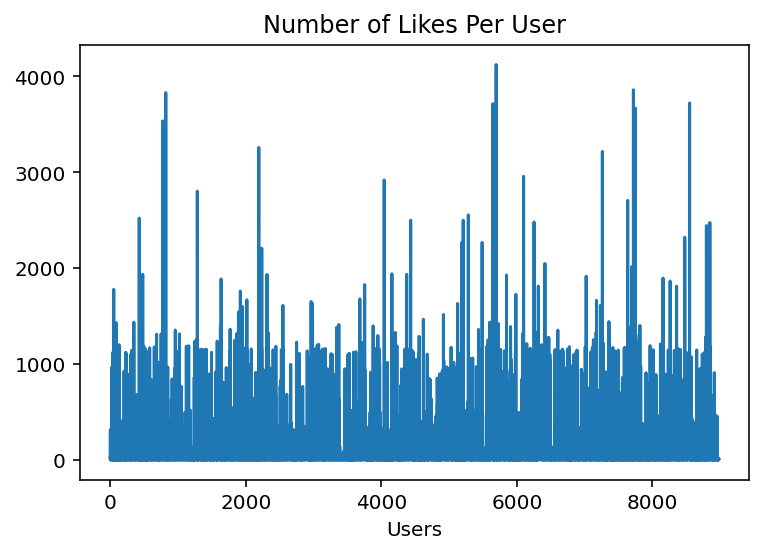

In [ ]:
data = np.loadtxt('data/social/data/spatial_data.txt')
FBSpatial = data[:,1:]
FBSnorm = np.linalg.norm(FBSpatial,axis=1,ord=1)
plt.plot(FBSnorm)
plt.title('Number of Likes Per User')
plt.xlabel('Users')

Now let's check whether the low dimensional phenomenon holds.

Text(0, 0.5, '$\\sigma_k$')

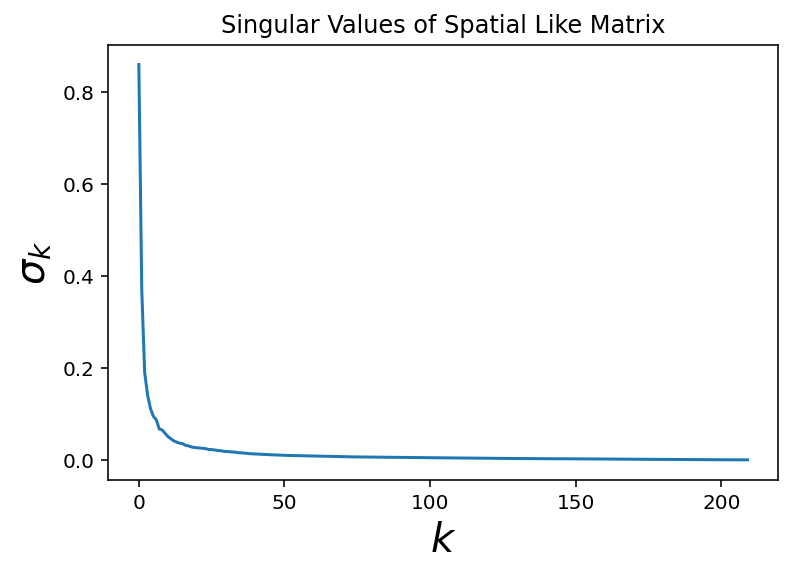

In [ ]:
u,s,vt = np.linalg.svd(FBSpatial,full_matrices=False)
plt.plot(s/np.linalg.norm(FBSpatial))
plt.title('Singular Values of Spatial Like Matrix')

plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)

Now let's 

1. Separate the portion of the data lying in the normal space from the amonalous space,
2. Identify the top 30 anomalous users (having the largest anomalous component), and
3. Plot their total number of likes against the set of all users.

*Araldo*: Here, I modified a bit the code with respect to the original  notebook.

Text(0.5, 1.0, 'Top 30 Anomalous Users')

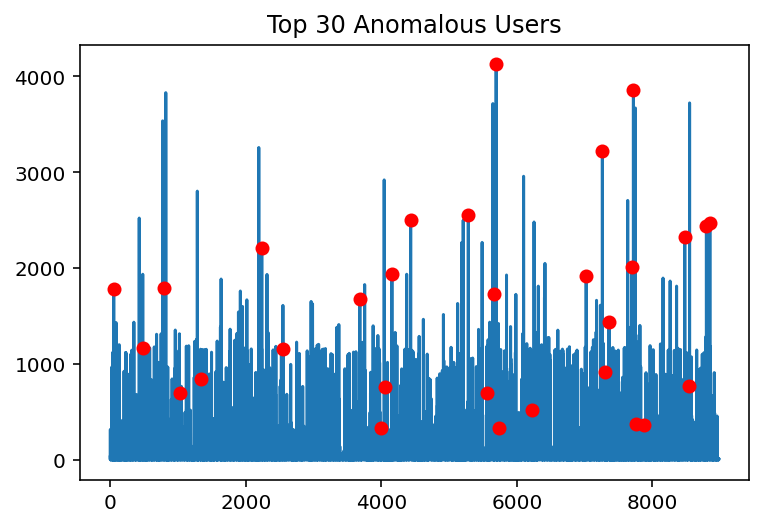

In [ ]:
u_prime = u[:,0:25]
sigma_prime = np.diag(s[0:25])
v_prime_t = vt[0:25,:]

N = np.dot(u_prime, np.dot(sigma_prime, v_prime_t) )

O = FBSpatial - N
Onorm = np.linalg.norm(O,axis=1)
# large = np.nonzero(Onorm>100))
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(FBSnorm)
plt.plot(anomSet,FBSnorm[anomSet],'ro')
plt.title('Top 30 Anomalous Users')

*Araldo* In paper[1] the authors can evaluate the performance of their anomaly detector, based on ground truth (some samples that represent true anomalous users and true normal users).

Next we'll pick out nine anomalous users and look at their pattern of likes across the 210 categories.

Text(0.5, 0.98, 'Nine Example Anomalous Users')

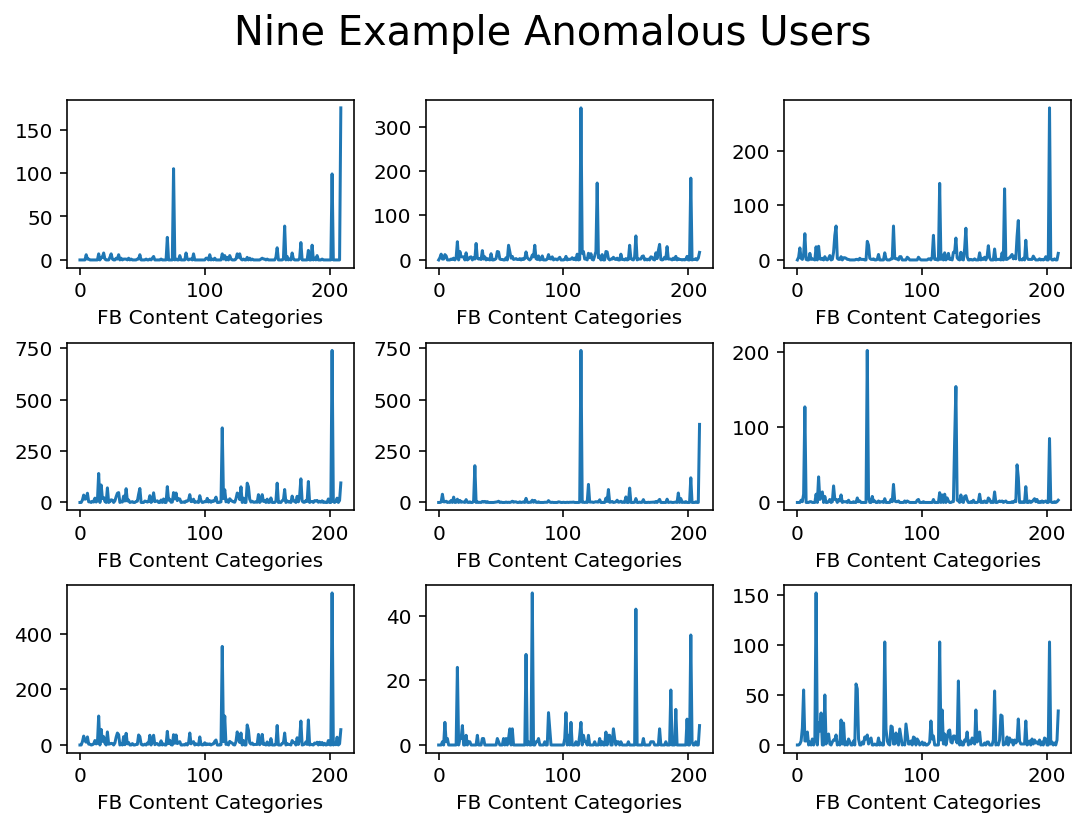

In [ ]:
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[anomSet[i-1],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Users',size=20)

And let's do the same for nine normal users.

Text(0.5, 0.98, 'Nine Example Normal Users')

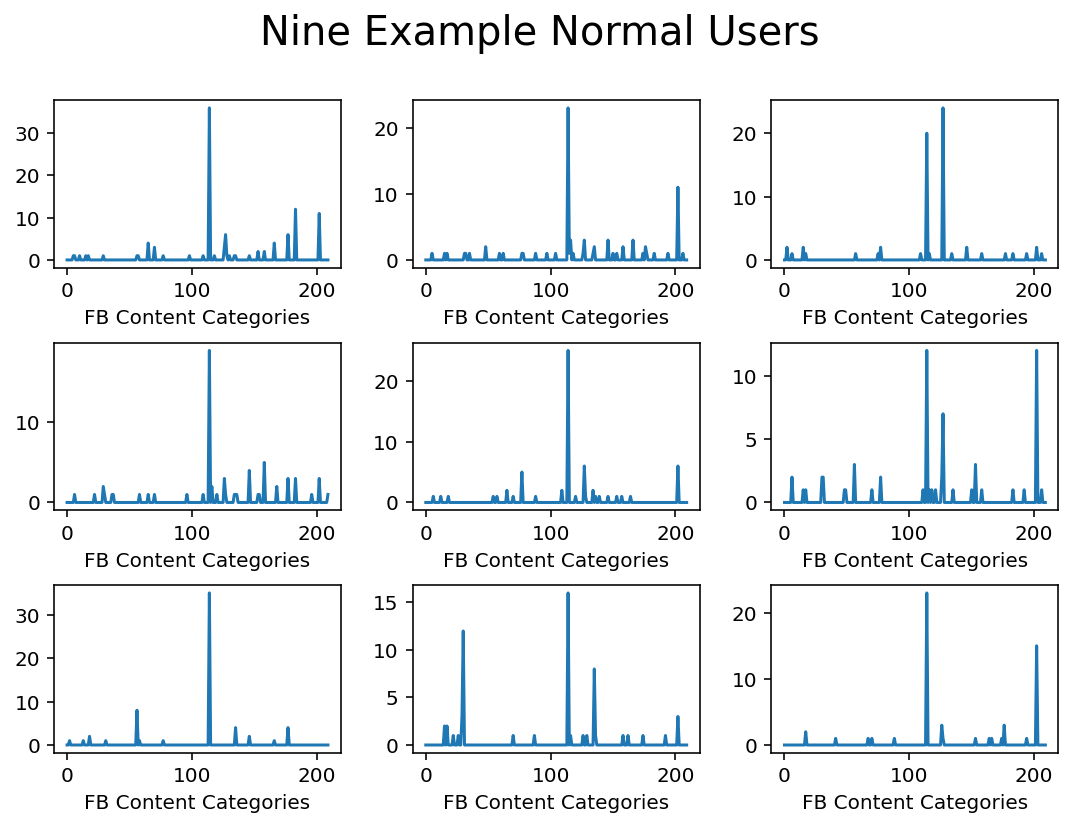

In [ ]:
# choose non-anomalous users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBSnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[set[max[i-1]],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Users',size=20)

*Araldo*: Look at the scale of these plots. Users classified as anomalous have a much higher activity.

### Example 3: Facebook Temporal LIkes

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, on a daily basis

Rows are users, Columns are days.

First we'll look at the singular values.

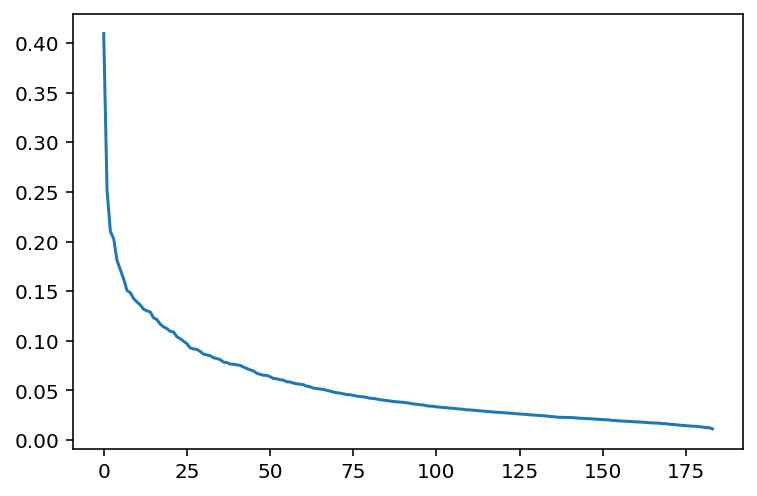

In [ ]:
data = np.loadtxt('data/social/data/temporal_data.txt')
FBTemporal = data[:,1:]
FBTnorm = np.linalg.norm(FBTemporal,axis=1,ord=1)
u,s,vt = np.linalg.svd(FBTemporal,full_matrices=False)
plt.plot(s/np.linalg.norm(FBTemporal))

Next, plot the anomalous users as before.

*Araldo*: I changed a bit the code with respect to the original notebook to match the 
equations

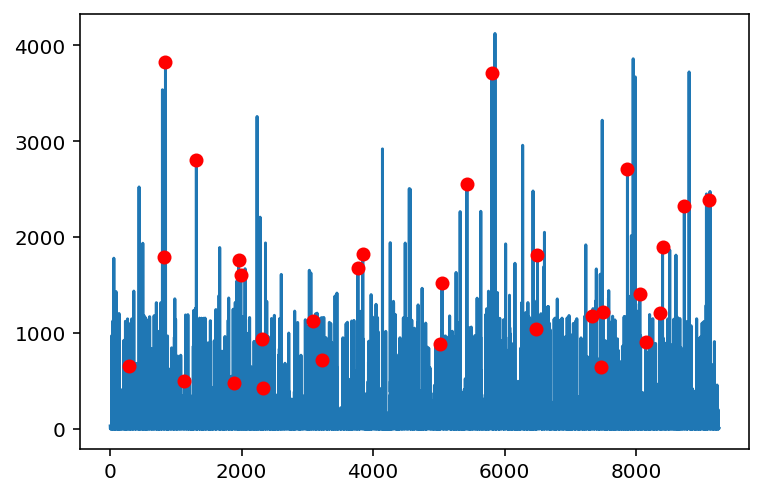

In [ ]:
u_prime = u[:,0:24]
sigma_prime = np.diag(s[0:24])
v_prime_t = vt[0:24,:]

N = np.dot(u_prime, np.dot(sigma_prime, v_prime_t) )

O = FBTemporal - N
Onorm = np.linalg.norm(O,axis=1)
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(FBTnorm)
plt.plot(anomSet,FBTnorm[anomSet],'ro')

Now let's look at sample anomalous and normal users.   

Text(0.5, 0.98, 'Nine Example Anomalous Users')

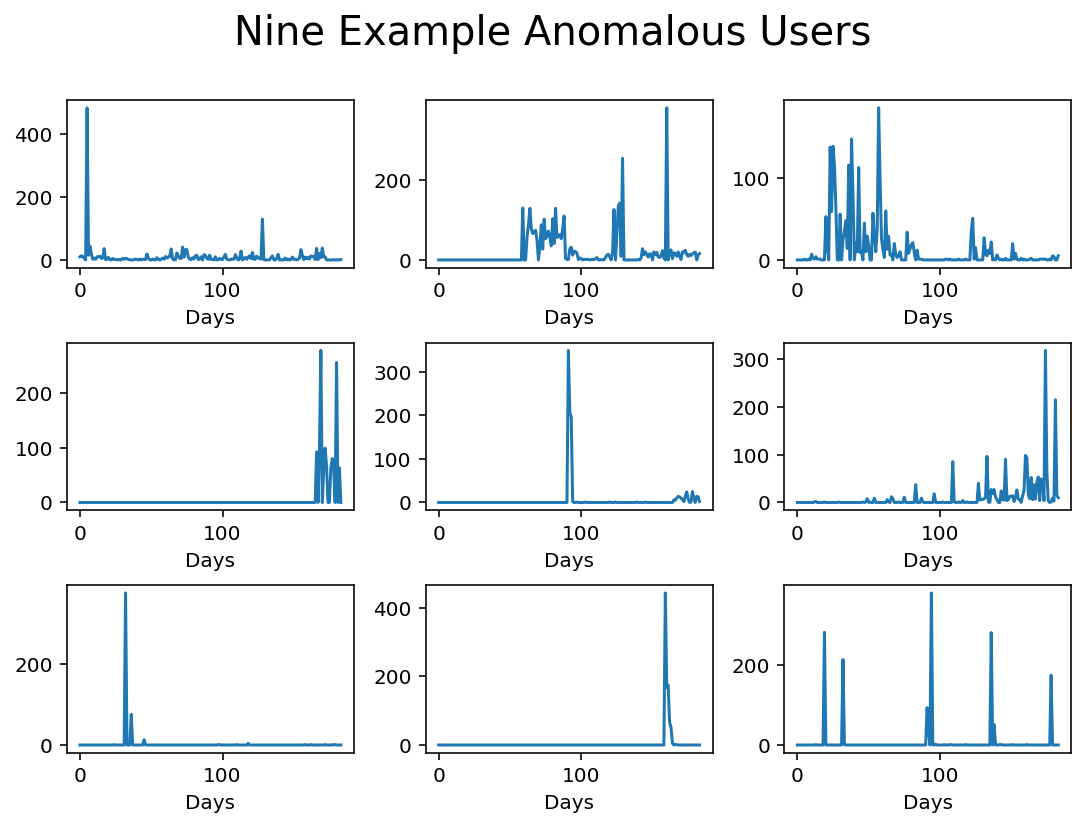

In [ ]:
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBTemporal[anomSet[i-1],:])
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Users',size=20)

Text(0.5, 0.98, 'Nine Example Normal Users')

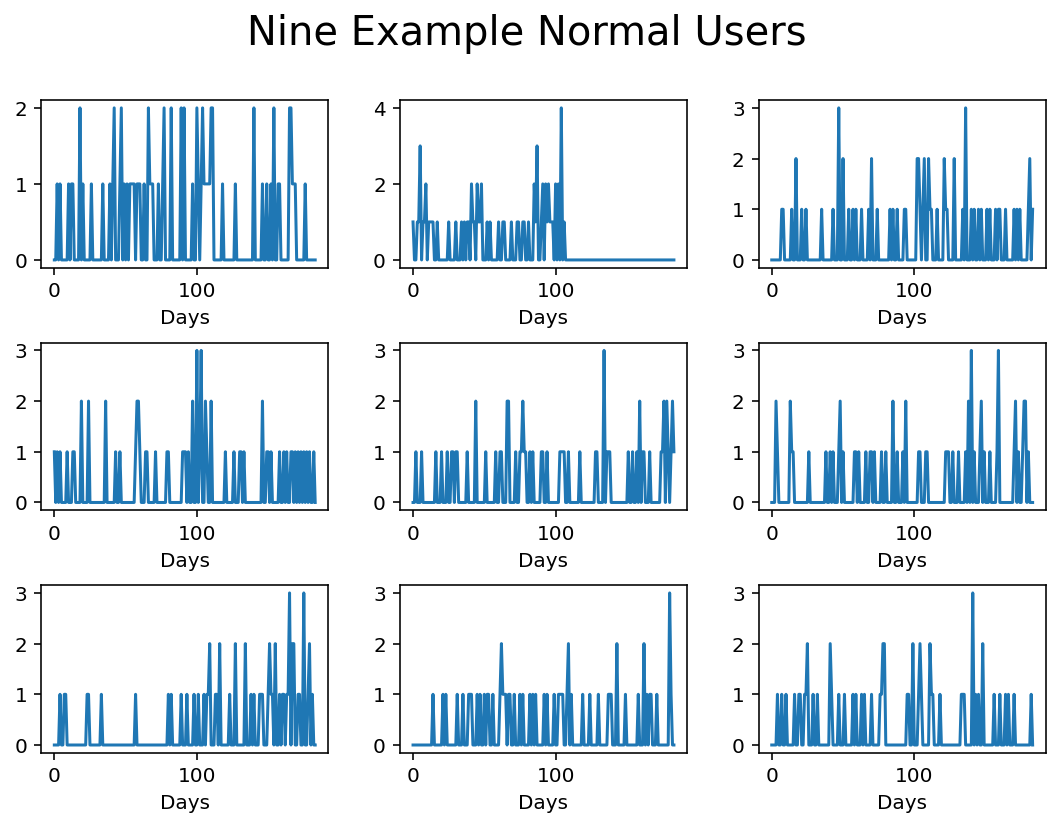

In [ ]:
# choose non-anomalous users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBTnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBTemporal[set[max[i-1]],:])
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Users',size=20)

Interestingly, what makes a user anomalous seems to have reversed from the case of the spatial data.

*Araldo*: Anomalous users are active less regularly but with high activity.

## Bibliography

The results in this lecture are mostly self-contained.   However here are some papers that show various aspects of using these ideas in practice.
<table>
  <tr>
<td valign="baseline" align="left" class="p">
[1]
 Bimal Viswanath, Muhammad Ahmad Bashir, Mark Crovella, Saikat Guha, Krishna Gummadi, Balachander Krishnamurthy and Alan Mislove (2014).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/usesec14-facebook-subspace.pdf">Towards Detecting Anomalous User Behavior in Online Social Networks.</a><br>In: <em>Proceedings of USENIX Security</em>. San Diego, CA. <a href="http://dx.doi.org/TBD">
	doi:TBD</a></td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[2]
Gonca Gürsun and Mark Crovella (2012).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/imc12-tm-completion.pdf">On Traffic Matrix Completion in the Internet.</a><br>In: <em>Proceedings of the Internet Measurement Conference (IMC)</em>. Boston, MA. <a href="http://dx.doi.org/10.1145/2398776.2398818">
	doi:10.1145/2398776.2398818</a></td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[3]
Vineet Bharti, Pankaj Kankar, Lokesh Setia, Gonca Gürsun, Anukool Lakhina and Mark Crovella (2010).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/conext10-invisible.pdf">Inferring Invisible Traffic.</a><br>In: <em>Proceedings of CoNEXT</em>. <a href="http://dx.doi.org/10.1145/1921168.1921197">
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[4]
David B. Chua, Eric D. Kolaczyk and Mark Crovella (2006).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/Network_Kriging.pdf">Network Kriging.</a><br>In: <em>IEEE Journal on Selected Areas in Communications, Special Issue on Sampling the Internet</em>, 24(12):2263--2272. 
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[5]
Anukool Lakhina, Mark Crovella and Christophe Diot (2005).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/flocon05.pdf">Detecting Distributed Attacks using Network-Wide Flow Traffic.</a><br>In: <em>Proceedings of FloCon 2005 Analysis Workshop</em>. 
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[6]
Anukool Lakhina, Mark Crovella and Christophe Diot (2005).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/sigc05-mining-anomalies.pdf">Mining Anomalies Using Traffic Feature Distributions.</a><br>In: <em>Proceedings of ACM SIGCOMM 2005</em>. pp. 217--228. <br><div class="note"><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/mining-anomalies-TR.pdf">
			[ Earlier (Full) Version, published as BUCS Technical Report BUCS-TR-2005-002 ]
                    </a></div>
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[7]
Anukool Lakhina, Mark Crovella and Christophe Diot (2004).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/imc04-characterizing-network-wide.pdf">Characterization of Network-Wide Anomalies in Traffic Flows.</a><br>In: <em>Proceedings of the ACM/SIGCOMM Internet Measurement Conference</em>. pp. 201--206. </td>
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[8]
Anukool Lakhina, Mark Crovella and Christophe Diot (2004).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/sigc04-network-wide-anomalies.pdf">Diagnosing Network-Wide Traffic Anomalies.</a><br>In: <em>Proceedings of ACM SIGCOMM 2004</em>. pp. 219--230. </td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[9]
Anukool Lakhina, Mark Crovella and Christophe Diot (2004).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/troubleshooting-sigc04.pdf">Exploring the Subspace Method for Network-Wide Anomaly Diagnosis (Poster Paper).</a><br>In: <em>Proceedings of ACM SIGCOMM Workshop on Network Troubleshooting</em>. pp. 319. </td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[10]
Anukool Lakhina, Konstantina Papagiannaki, Mark Crovella, Christophe Diot, Eric D. Kolaczyk and Nina Taft (2004).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/sigm04-odflows.pdf">Structural Analysis of Network Traffic Flows.</a><br>In: <em>Proceedings of ACM SIGMETRICS / Performance 2004</em>. pp. 61--72. <br><div class="note"><a href="http://www.cs.bu.edu/techreports/pdf/2003-021-odflows.pdf">
			[ Earlier version. Published as BUCS Technical Report BUCS-TR-2003-021 and Sprint Research Report RR03-ATL-110708 ]
</td>
</tr>

<tr>
<td valign="baseline" align="left" class="p">
[11]
Härdle, W. K., & Simar, L. (2015). Applied multivariate statistical analysis, fourth edition. Applied Multivariate Statistical Analysis, Fourth Edition (4th ed.). https://doi.org/10.1007/978-3-662-45171-7
</td>
</tr>

<tr>
<td valign="baseline" align="left" class="p">
[12]
[Singular Value Decomposition](https://online.stat.psu.edu/stat555/node/94/), STAT 555, Statistical Analysis of Genomics Data, PennState University.
</table>


